# NDBC Statistics

This notebook contains code used to view, manipulate, and analyze buoy data from buoys stationed in the Great Lakes and connected to the NDBC network

## Initial Workflow
Find buoy of interest in [NDCB Map](https://www.ndbc.noaa.gov/) --> In historical data, find the year of interest in the standard meteoroligical data category (note Great Lakes buoys do not collect spectral wave data) --> Save the .txt file and name it using the convention "exampleplace_year.txt" --> Load "exampleplace_year.txt" into a pandas dataframe --> Change date columns into a datetime object --> Change 99.00 or 999.00 values into NaN --> Drop NaN values and columns that are irrelevant to wave data

### Load data into Pandas

In [104]:
import pandas as pd
import numpy as np

mkg_2020 = pd.read_csv("muskegon_2020.txt", skiprows=range(1,2), delim_whitespace = True, parse_dates={'date':[0,1,2,3,4]}, keep_date_col=False)
mkg_2020.head()

,date,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2020 07 30 13 20,55,3.5,4.3,0.14,2.41,99.0,312,1014.7,21.3,23.9,999.0,99.0,99.0
1,2020 07 30 13 40,52,3.7,4.5,0.12,99.00,99.0,321,1014.7,21.4,24.0,999.0,99.0,99.0
2,2020 07 30 14 00,47,4.6,6.1,0.14,2.04,99.0,257,1014.7,21.6,24.1,999.0,99.0,99.0
3,2020 07 30 14 20,47,3.6,5.1,0.15,99.00,99.0,311,1014.8,22.0,24.1,999.0,99.0,99.0
4,2020 07 30 14 40,53,2.6,3.8,0.14,99.00,99.0,66,1014.7,22.5,24.1,999.0,99.0,99.0


### Turn date column into a pandas datetime object

In [105]:
mkg_2020['Timestamp'] = pd.to_datetime(mkg_2020['date'], format = '%Y %m %d %H %M')
mkg_2020.head()

,date,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,Timestamp
0,2020 07 30 13 20,55,3.5,4.3,0.14,2.41,99.0,312,1014.7,21.3,23.9,999.0,99.0,99.0,2020-07-30 13:20:00
1,2020 07 30 13 40,52,3.7,4.5,0.12,99.00,99.0,321,1014.7,21.4,24.0,999.0,99.0,99.0,2020-07-30 13:40:00
2,2020 07 30 14 00,47,4.6,6.1,0.14,2.04,99.0,257,1014.7,21.6,24.1,999.0,99.0,99.0,2020-07-30 14:00:00
3,2020 07 30 14 20,47,3.6,5.1,0.15,99.00,99.0,311,1014.8,22.0,24.1,999.0,99.0,99.0,2020-07-30 14:20:00
4,2020 07 30 14 40,53,2.6,3.8,0.14,99.00,99.0,66,1014.7,22.5,24.1,999.0,99.0,99.0,2020-07-30 14:40:00


### Remove Irrelvant Data
The old date column is no longer needed and the only data relevant to me are those that represent direct measurement of waves

In [80]:
# There must be a more pythonic way to index through these
mkgwave2020 = mkg_2020.drop(mkg_2020.columns[[0,1,2,3,6,8,9,10,11,12, 13]], axis = 1) 

# Remove rows that have no information for either wave height or period
mkgwave2020 = mkgwave2020.replace(to_replace = 99.00, value = np.nan)
mkgwave2020 = mkgwave2020.dropna() 

mkgwave2020.head()

,WVHT,DPD,MWD,Timestamp
0,0.14,2.41,312.0,2020-07-30 13:20:00
2,0.14,2.04,257.0,2020-07-30 14:00:00
5,0.12,2.13,14.0,2020-07-30 15:00:00
6,0.13,2.09,47.0,2020-07-30 15:20:00
7,0.12,2.01,263.0,2020-07-30 15:40:00


### Plotting wave height and period overtime

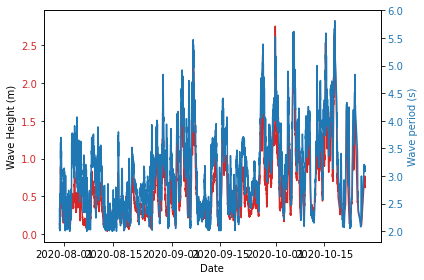

In [83]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Wave Height (m)')
ax1.plot(mkgwave2020['Timestamp'], mkgwave2020['WVHT'].values, color =color)
ax1.tick_params(axis = 'y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Wave period (s)', color = color)
ax2.plot(mkgwave2020['Timestamp'], mkgwave2020['DPD'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Function for data prep
Based on the code above, create a function that takes a list of .txt files from a single NDCB buoy and returns a single pandas dataframe of relevant wave data across all years represented. 

In [110]:
#define function
def wavetxt2waveframe(txtlist):
    '''Takes a list of multiple years of .txt files from a NDCB buoy 
    standard meteorological data and returns a single pandas dataframe that only contains
    wave height, dominant period, wave direction, and a timestamp in the form of a pandas datetime object'''
   
    # create an empty list that will hold the opened txt files
    framelist = []
    
    # Loop through each txt file and read it into a pandas dataframe
    for txt in txtlist:
        framelist.append(pd.read_csv(txt, skiprows=range(1,2), delim_whitespace = True, \
                                     parse_dates={'date':[0,1,2,3,4]}, keep_date_col=False))
    
    # concatenate the dataframes
    waveframe = pd.concat(framelist, ignore_index = True)
   
    # Transfer data in "date" column to a column where it is stored as a datetime object
    waveframe['Timestamp'] = pd.to_datetime(waveframe['date'], format = '%Y %m %d %H %M')
    
    
    # There must be a more pythonic way to index through these
    waveframe = waveframe.drop(waveframe.columns[[0,1,2,3,6,8,9,10,11,12, 13]], axis = 1) 

    # Remove rows that have no information for either wave height or period
    waveframe = waveframe.replace(to_replace = 99.00, value = np.nan)
    waveframe = waveframe.dropna() 

    return waveframe
        

In [111]:
# test function

buoydata = ["muskegon_2015.txt", "muskegon_2016.txt", "muskegon_2017.txt", "muskegon_2018.txt", \
           "muskegon_2019.txt", "muskegon_2020.txt"]

wavetxt2waveframe(buoydata)

,WVHT,DPD,MWD,Timestamp
0,0.58,2.99,268.0,2015-05-13 17:40:00
1,0.56,3.01,277.0,2015-05-13 18:00:00
2,0.53,2.95,273.0,2015-05-13 18:20:00
3,0.55,2.99,267.0,2015-05-13 18:40:00
4,0.54,2.89,270.0,2015-05-13 19:00:00
...,...,...,...,...
62777,0.71,3.21,317.0,2020-10-26 15:00:00
62783,0.69,3.08,320.0,2020-10-26 17:00:00
62789,0.77,3.19,326.0,2020-10-26 19:00:00
62795,0.71,3.18,327.0,2020-10-26 21:00:00
